## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import xgboost as xgb

import urllib.request

In [75]:
# FUNCIONES

def nombre_processor(text):
    if text == 'Intel Core i7' or text == 'Intel Core i5' or text == 'Intel Core i3':
        return text
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        else:
            return 'AMD Processor'

In [76]:
import pandas as pd
import re
def process_memory(df):
    """
    Extracts storage information into standardized columns.
    Returns DataFrame with new storage columns.
    """
    df_clean = df.copy()
    def transform_storage(storage_str):
        """
        Transforma una cadena de texto de almacenamiento en valores numéricos y booleanos.
        
        Args:
            storage_str (str): Cadena de texto que describe el almacenamiento
            
        Returns:
            tuple: (total_storage_GB, has_SSD, has_HDD)
        """
        # Inicializar variables
        total_gb = 0
        has_ssd = False
        has_hdd = False
        
        # Convertir a minúsculas para estandarizar
        storage_str = storage_str.lower()
        
        # Función auxiliar para convertir a GB
        def to_gb(value, unit):
            if 'tb' in unit:
                return float(value) * 1024
            return float(value)
        
        # Buscar todos los patrones de almacenamiento (número + unidad)
        storage_parts = storage_str.split('+')
        
        for part in storage_parts:
            part = part.strip()
            
            # Extraer número y tipo
            match = re.search(r'([\d.]+)\s*([tg]b)\s*((?:ssd|hdd|flash|hybrid))', part)
            if match:
                value, unit, type_ = match.groups()
                gb_value = to_gb(value, unit)
                total_gb += gb_value
                
                # Marcar tipo de almacenamiento
                if 'ssd' in type_ or 'flash' in type_:
                    has_ssd = 1
                elif 'hdd' in type_:
                    has_hdd = 1
                elif 'hybrid' in type_:
                    has_ssd = 1
                    has_hdd = 1
                
        
        return pd.Series({
            'SSD': has_ssd,
            'HDD': has_hdd,
            'Total_Storage_GB': total_gb,
            
        })
    storage_info = df_clean['Memory'].apply(transform_storage)
    df_clean = pd.concat([df_clean, storage_info], axis=1)
    
    return df_clean

# # Ejemplo de uso con un DataFrame
# def transform_storage_column(df, storage_column='storage'):
#     """
#     Transforma la columna de almacenamiento de un DataFrame en tres nuevas columnas.
    
#     Args:
#         df (pandas.DataFrame): DataFrame con la columna de almacenamiento
#         storage_column (str): Nombre de la columna de almacenamiento
        
#     Returns:
#         pandas.DataFrame: DataFrame con las nuevas columnas añadidas
#     """
#     results = df[storage_column].apply(transform_storage)
    
#     df['Total_storage_GB'] = [x[0] for x in results]
#     df['has_SSD'] = [x[1] for x in results]
#     df['has_HDD'] = [x[2] for x in results]
    
#     return df

In [77]:
def process_storage(df):
    """
    Extracts storage information into standardized columns.
    Returns DataFrame with new storage columns.
    """
    df_clean = df.copy()
    
    def extract_storage_info(storage_str):
        total_ssd = 0
        total_hdd = 0
        flash_storage = 0
        
        # Convert TB to GB
        storage_str = storage_str.replace('TB', '000GB')
        storage_str = storage_str.replace('.0TB', '000GB')
        
        parts = storage_str.split('+')
        for part in parts:
            part = part.strip()
            size = float(part.split('GB')[0])
            
            if 'SSD' in part:
                total_ssd += size
            elif 'HDD' in part:
                total_hdd += size
            elif 'Flash Storage' in part:
                flash_storage += size
            elif 'Hybrid' in part:
                total_hdd += size
        
        # Determine storage type
        if total_ssd > 0 and total_hdd > 0:
            storage_type = 'SSD+HDD'
        elif total_ssd > 0:
            storage_type = 'SSD'
        elif total_hdd > 0:
            storage_type = 'HDD'
        elif flash_storage > 0:
            storage_type = 'Flash'
        else:
            storage_type = 'Unknown'
        
        return pd.Series({
            'SSD_GB': total_ssd,
            'HDD_GB': total_hdd,
            'Flash_GB': flash_storage,
            'Total_Storage_GB': total_ssd + total_hdd + flash_storage,
            'Storage_Type': storage_type
        })
    
    storage_info = df_clean['Memory'].apply(extract_storage_info)
    df_clean = pd.concat([df_clean, storage_info], axis=1)
    
    return df_clean

In [78]:
def card_tipo(df,umbral_categoria = 10, umbral_continua = 30):
    # Primera parte: Preparo el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_temp = df_temp.T # Como nos da los valores de las columnas en columnas, y quiero que estas sean filas, la traspongo
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) 
    # Cambio el nombre de la transposición anterior para que tengan más sentido, y uso asignación en vez de inplace = True (esto es arbitrario para el tamaño de este dataset)

    # Corrección para cuando solo tengo un valor
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

    # Creo la columna de sugerenica de tipo de variable, empiezo considerando todas categóricas pero podría haber empezado por cualquiera, siempre que adapte los filtros siguientes de forma correspondiente
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"
    # Ojo los filtros aplicados cumplen con el enunciado pero no siguen su orden y planteamiento

    return df_temp

## Datos

In [79]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("./data/train.csv", index_col = 0)
#df.index.name = None # quitamos el nombre al index

## Exploración de los datos

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [81]:
len(df[df.duplicated])
print("El dataset tiene", len(df[df.duplicated]), "duplicados")
#hay duplicados, quitarlos

El dataset tiene 21 duplicados


In [82]:
df.drop_duplicates(inplace=True)

In [83]:
df.index.name = None

#DROP Product
df.drop('Product', axis= 1, inplace = True)

In [84]:
#df = process_memory(df)

In [85]:
df

Company            TypeName  Inches                 ScreenResolution  \
755       HP            Notebook    15.6                Full HD 1920x1080   
618     Dell              Gaming    15.6                Full HD 1920x1080   
909       HP            Notebook    15.6                Full HD 1920x1080   
2      Apple           Ultrabook    13.3                         1440x900   
286     Dell            Notebook    15.6                Full HD 1920x1080   
...      ...                 ...     ...                              ...   
28      Dell            Notebook    15.6                Full HD 1920x1080   
1160      HP  2 in 1 Convertible    13.3  Full HD / Touchscreen 1920x1080   
78    Lenovo            Notebook    15.6                Full HD 1920x1080   
23        HP            Notebook    15.6                         1366x768   
229     Dell              Gaming    17.3      IPS Panel Full HD 1920x1080   

                               Cpu   Ram                Memory  \
755       Intel Core i3 6006U 2GHz   8GB             256GB SSD   
618    Intel Core i7 6700HQ 2.6GHz  16GB               1TB HDD   
909     Intel Core i7 7500U 2.7GHz   8GB               1TB HDD   
2             Intel Core i5 1.8GHz   8GB   128GB Flash Storage   
286     Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
...                            ...   ...                   ...   
28      Intel Core i5 8250U 1.6GHz   8GB             256GB SSD   
1160    Intel Core i5 6300U 2.4GHz   8GB             256GB SSD   
78      Intel Core i5 7200U 2.5GHz   8GB               2TB HDD   
23    AMD E-Series E2-9000e 1.5GHz   4GB             500GB HDD   
229    Intel Core i7 7700HQ 2.8GHz  16GB  256GB SSD +  1TB HDD   

                                 Gpu       OpSys  Weight  Price_in_euros  
755            Intel HD Graphics 520  Windows 10  1.86kg          539.00  
618   Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg          879.01  
909             Nvidia GeForce 930MX  Windows 10  2.04kg          900.00  
2             Intel HD Graphics 6000       macOS  1.34kg          898.94  
286               AMD Radeon R5 M430       Linux  2.25kg          428.00  
...                              ...         ...     ...             ...  
28                    AMD Radeon 530  Windows 10   2.2kg          800.00  
1160           Intel HD Graphics 520  Windows 10  1.48kg         1629.00  
78             Intel HD Graphics 620       No OS   2.2kg          519.00  
23                     AMD Radeon R2       No OS  1.86kg          258.00  
229          Nvidia GeForce GTX 1060  Windows 10  4.42kg         2456.34  

[891 rows x 11 columns]

In [89]:
def transform(df):
    #Ordinal Encoder Company
   #  brands = df.Company.value_counts()[df.Company.value_counts() <= 5].index
   #  df.loc[df['Company'].isin(brands), 'Company'] = 'OthersCompany'
    Company_order = ['Vero',
 'Chuwi',
 'Mediacom',
 'Acer',
 'Fujitsu',
 'Lenovo',
 'Asus',
 'HP',
 'Dell',
 'Xiaomi',
 'Toshiba',
 'Samsung',
 'Huawei',
 'Apple',
 'MSI',
 'Microsoft',
 'Google',
 'LG',
 'Razer']
    # Aplicar OrdinalEncoder con categorías en el orden definido
    encoder_company = OrdinalEncoder(categories=[Company_order])
    df['company_encoded'] = encoder_company.fit_transform(df[['Company']])

    #Ordinal Encoder TypeName
    type_order = ['Netbook',
 'Notebook',
 '2 in 1 Convertible',
 'Ultrabook',
 'Gaming',
 'Workstation']
    # Aplicar OrdinalEncoder con categorías en el orden definido
    encoder_tipo = OrdinalEncoder(categories=[type_order])
    df['Tipo_encoded'] = encoder_tipo.fit_transform(df[['TypeName']])

    df["inches"] = df.Inches.astype(float)

    #Transformacion ScreenResolution
    df['touchscreen'] = df['ScreenResolution'].apply(lambda x:1 if "Touchscreen" in x else 0)
    df['FullHD'] = df['ScreenResolution'].apply(lambda x:1 if "Full HD" in x else 0)
    df['ips'] = df['ScreenResolution'].apply(lambda x:1 if 'IPS' in x else 0)

    #Transformacion Cpu
    df['CpuName'] = df['Cpu'].apply(lambda x :" " .join(x.split()[:3]))
    df['CpuName1'] = df['Cpu'].apply(lambda x :" " .join(x.split()[:1]))
    encoder_cpu = OrdinalEncoder()
    df['cpu_name1_encoded'] = encoder_cpu.fit_transform(df[['CpuName1']])
    df['CpuName2'] = df['Cpu'].apply(lambda x :" " .join(x.split()[:2]))
    df['cpu_ghz'] = (df['Cpu'].apply(lambda x :"" .join(x.split()[-1]))).str.replace('GHz', '').astype(float)
    df['Cpu_brand'] = df['CpuName'].apply(nombre_processor)

    df['ram_gb'] = df['Ram'].str.replace('GB', '').astype(int)

    df['gpu_brand']  = df['Gpu'].apply(lambda x:x.split()[0])
    encoder_gpu = OrdinalEncoder()
    df['gpu_brand_encoded'] = encoder_gpu.fit_transform(df[['gpu_brand']])

    # funcion process_storage transforma la columna memory
    #df = process_storage(df)   # df con la columna storage transformada en 4 columnas que tienen en cuenta el total de GB de storage
    df = process_memory(df) # df con la columna storage transformada en 3 columnas que tienen en cuenta el total de GB de storage y si es SSD o HHD
    df['es_SSD'] = df['SSD'].astype(int)
    df['es_HDD'] = df['HDD'].astype(int)


    #Ordinal Encoder OpSys
    OS_order = ['Android',
 'Chrome OS',
 'No OS',
 'Linux',
 'Windows 10',
 'Mac OS X',
 'Windows 10 S',
 'Windows 7',
 'macOS']
    encoder_OS = OrdinalEncoder(categories=[OS_order])
    df['OS_encoded'] = encoder_OS.fit_transform(df[['OpSys']])

    df["weight_kg"] = df['Weight'].str.replace('kg', '').astype(float)

    return df

In [90]:
df = transform(df)

In [ ]:
df.groupby('OpSys')['Price_in_euros'].mean().sort_values().index.tolist()

['Android',
 'Chrome OS',
 'No OS',
 'Linux',
 'Windows 10',
 'Mac OS X',
 'Windows 10 S',
 'Windows 7',
 'macOS']

In [88]:
df.groupby('Company')['Price_in_euros'].mean().sort_values().index.tolist()

['Vero',
 'Chuwi',
 'Mediacom',
 'Acer',
 'Fujitsu',
 'Lenovo',
 'Asus',
 'HP',
 'Dell',
 'Xiaomi',
 'Toshiba',
 'Samsung',
 'Huawei',
 'Apple',
 'MSI',
 'Microsoft',
 'Google',
 'LG',
 'Razer']

In [46]:
df.groupby('TypeName')['Price_in_euros'].mean().sort_values().index.tolist()

['Netbook',
 'Notebook',
 '2 in 1 Convertible',
 'Ultrabook',
 'Gaming',
 'Workstation']

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 755 to 229
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            891 non-null    object 
 1   TypeName           891 non-null    object 
 2   Inches             891 non-null    float64
 3   ScreenResolution   891 non-null    object 
 4   Cpu                891 non-null    object 
 5   Ram                891 non-null    object 
 6   Memory             891 non-null    object 
 7   Gpu                891 non-null    object 
 8   OpSys              891 non-null    object 
 9   Weight             891 non-null    object 
 10  Price_in_euros     891 non-null    float64
 11  company_encoded    891 non-null    float64
 12  Tipo_encoded       891 non-null    float64
 13  inches             891 non-null    float64
 14  touchscreen        891 non-null    int64  
 15  FullHD             891 non-null    int64  
 16  ips                891 non-nu

In [24]:
df.describe()

Inches  Price_in_euros  company_encoded  Tipo_encoded     inches  \
count  891.00000      891.000000       891.000000    891.000000  891.00000   
mean    14.98642     1122.550797         3.859708      1.950617   14.98642   
std      1.44241      690.244047         2.007140      1.278969    1.44241   
min     10.10000      174.000000         0.000000      0.000000   10.10000   
25%     14.00000      597.000000         2.000000      1.000000   14.00000   
50%     15.60000      997.900000         4.000000      1.000000   15.60000   
75%     15.60000     1496.500000         5.000000      3.000000   15.60000   
max     18.40000     6099.000000        10.000000      5.000000   18.40000   

       touchscreen      FullHD         ips  cpu_name1_encoded     cpu_ghz  \
count   891.000000  891.000000  891.000000         891.000000  891.000000   
mean      0.142536    0.643098    0.273850           0.953984    2.289203   
std       0.349796    0.479355    0.446183           0.209637    0.515258   
min       0.000000    0.000000    0.000000           0.000000    0.900000   
25%       0.000000    0.000000    0.000000           1.000000    1.800000   
50%       0.000000    1.000000    0.000000           1.000000    2.500000   
75%       0.000000    1.000000    1.000000           1.000000    2.700000   
max       1.000000    1.000000    1.000000           1.000000    3.600000   

           ram_gb  gpu_brand_encoded  
count  891.000000         891.000000  
mean     8.316498           1.185185  
std      5.057284           0.639913  
min      2.000000           0.000000  
25%      4.000000           1.000000  
50%      8.000000           1.000000  
75%      8.000000           2.000000  
max     64.000000           2.000000

In [27]:
card_tipo(df)

Card     %_Card     Tipo      tipo_sugerido
Company             11   1.234568   object  Numerica discreta
TypeName             6   0.673401   object         Categorica
Inches              17   1.907969  float64  Numerica discreta
ScreenResolution    36   4.040404   object  Numerica discreta
Cpu                107  12.008979   object  Numerica discreta
Ram                  9   1.010101   object         Categorica
Memory              37   4.152637   object  Numerica discreta
Gpu                 93   10.43771   object  Numerica discreta
OpSys                9   1.010101   object         Categorica
Weight             165  18.518519   object  Numerica discreta
Price_in_euros     603  67.676768  float64  Numerica continua
company_encoded     11   1.234568  float64  Numerica discreta
Tipo_encoded         6   0.673401  float64         Categorica
inches              17   1.907969  float64  Numerica discreta
touchscreen          2   0.224467    int64            Binaria
FullHD               2   0.224467    int64            Binaria
ips                  2   0.224467    int64            Binaria
CpuName             35   3.928171   object  Numerica discreta
CpuName1             2   0.224467   object            Binaria
cpu_name1_encoded    2   0.224467  float64            Binaria
CpuName2            13   1.459035   object  Numerica discreta
cpu_ghz             25   2.805836  float64  Numerica discreta
Cpu_brand            5   0.561167   object         Categorica
ram_gb               9   1.010101    int64         Categorica
gpu_brand            3     0.3367   object         Categorica
gpu_brand_encoded    3     0.3367  float64         Categorica
SSD                  2   0.224467   object            Binaria
HDD                  2   0.224467   object            Binaria
Total_Storage_GB    22   2.469136  float64  Numerica discreta
es_SSD               2   0.224467    int64            Binaria
es_HDD               2   0.224467    int64            Binaria
OS_encoded           9   1.010101  float64         Categorica
weight_kg          158  17.732884  float64  Numerica discreta

STORAge TYPE transformarla en es_SSD (0,1) es_HHD (0,1) e Total Storage   --> Transformar la funcion Process_storage de Memory

verificar la columna Grafica

## Procesado de datos

Nuestro target es la columna `Price_in_euros`

SELECCIONAR LAS COLUMNAS 
VER CORR entre Numericas
VER Colinealidad
hacer un best model para features selected
hacer un RFE per features selected
hacer optimizacion mejor modelo



In [ ]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'Price_in_euros', 'SSD', 'HDD',
       'Total_Storage_GB', 'company_encoded', 'Tipo_encoded', 'inches',
       'touchscreen', 'FullHD', 'ips', 'CpuName', 'CpuName1', 'CpuName2',
       'cpu_ghz', 'Cpu_brand', 'ram_gb', 'gpu_brand', 'SSD', 'HDD',
       'Total_Storage_GB', 'OS_encoded', 'weight_kg'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 755 to 229
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            891 non-null    object 
 1   TypeName           891 non-null    object 
 2   Inches             891 non-null    float64
 3   ScreenResolution   891 non-null    object 
 4   Cpu                891 non-null    object 
 5   Ram                891 non-null    object 
 6   Memory             891 non-null    object 
 7   Gpu                891 non-null    object 
 8   OpSys              891 non-null    object 
 9   Weight             891 non-null    object 
 10  Price_in_euros     891 non-null    float64
 11  company_encoded    891 non-null    float64
 12  Tipo_encoded       891 non-null    float64
 13  inches             891 non-null    float64
 14  touchscreen        891 non-null    int64  
 15  FullHD             891 non-null    int64  
 16  ips                891 non-nu

In [ ]:
target = ['Price_in_euros']
feat_no_sel = ['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
       'Memory', 'Gpu', 'OpSys', 'Weight', 'SSD', 'HDD']
cat_cols_num = ['es_SSD', 'es_HDD', 'company_encoded', 'Tipo_encoded',
       'Total_Storage_GB', 'touchscreen', 'FullHD', 'ips', 'OS_encoded', 'gpu_brand_encoded', 'cpu_name1_encoded' ] # 
cat_col = ['gpu_brand', 'Cpu_brand', 'CpuName1']
num_cols = ['inches', 'cpu_ghz', 'ram_gb', 'weight_kg']
features = cat_cols_num  + num_cols
features_con_target = features + target


-----------------------------------------------------------------------------------------------------------------

In [124]:
features

['es_SSD',
 'es_HDD',
 'company_encoded',
 'Tipo_encoded',
 'Total_Storage_GB',
 'touchscreen',
 'FullHD',
 'ips',
 'OS_encoded',
 'inches',
 'cpu_ghz',
 'ram_gb',
 'weight_kg']

In [125]:
df[features_con_target].corr(numeric_only=True)['Price_in_euros'].sort_values(ascending=False)

Price_in_euros      1.000000
ram_gb              0.736241
Tipo_encoded        0.620303
cpu_ghz             0.425838
es_SSD              0.413801
company_encoded     0.372407
OS_encoded          0.309587
ips                 0.266948
FullHD              0.236936
touchscreen         0.217615
weight_kg           0.199311
Total_Storage_GB    0.182634
inches              0.070916
es_HDD             -0.152534
Name: Price_in_euros, dtype: float64

<Axes: xlabel='Price_in_euros', ylabel='Count'>

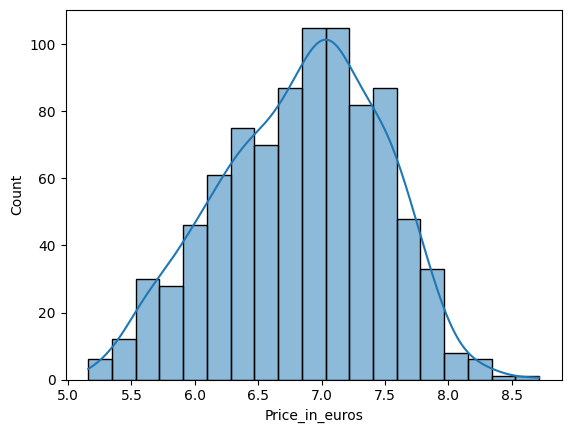

In [39]:
sns.histplot(np.log(df['Price_in_euros']), kde = True)

## Modelado

### 1. Definir X e y

In [40]:
# X = df.drop(['Price_in_euros'], axis=1)
# y = df[].copy()
# X.shape

In [127]:
X = df[features]
y = df['Price_in_euros']

### 2. Dividir X_train, X_test, y_train, y_test

In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

In [93]:
X_train

es_SSD  es_HDD  Total_Storage_GB  company_encoded  Tipo_encoded  \
112        1       0             256.0              5.0           1.0   
13         1       0             256.0             13.0           3.0   
1190       0       1             500.0              6.0           1.0   
55         0       1            1024.0              3.0           1.0   
1043       1       0             256.0              7.0           1.0   
...      ...     ...               ...              ...           ...   
578        0       1            2048.0              7.0           1.0   
336        1       1            1280.0             14.0           4.0   
20         1       0             128.0              8.0           3.0   
876        0       1             500.0              7.0           1.0   
418        1       0             512.0              5.0           3.0   

      touchscreen  FullHD  ips  OS_encoded  gpu_brand_encoded  \
112             0       1    1         4.0                1.0   
13              0       0    1         8.0                0.0   
1190            0       0    0         4.0                1.0   
55              0       0    0         4.0                1.0   
1043            0       1    0         4.0                2.0   
...           ...     ...  ...         ...                ...   
578             0       0    0         4.0                1.0   
336             0       1    0         4.0                2.0   
20              1       1    1         4.0                1.0   
876             0       1    0         4.0                1.0   
418             0       1    1         4.0                2.0   

      cpu_name1_encoded  inches  cpu_ghz  ram_gb  weight_kg  
112                 1.0    14.0      2.7       8       1.58  
13                  1.0    15.4      2.8      16       1.83  
1190                1.0    15.6      1.6       4       2.20  
55                  1.0    15.6      2.4       4       2.40  
1043                1.0    17.3      2.5       8       2.63  
...                 ...     ...      ...     ...        ...  
578                 1.0    14.0      1.6       8       1.94  
336                 1.0    17.3      2.8       8       2.70  
20                  1.0    13.3      1.6       8       1.22  
876                 1.0    15.6      2.3       4       2.07  
418                 1.0    14.0      2.8       8       1.70  

[712 rows x 15 columns]

In [32]:
X_train.describe()

es_SSD      es_HDD  Total_Storage_GB  company_encoded  \
count  712.000000  712.000000        712.000000       712.000000   
mean     0.726124    0.442416        604.207865         7.022472   
std      0.446260    0.497022        475.455304         2.840247   
min      0.000000    0.000000          8.000000         0.000000   
25%      0.000000    0.000000        256.000000         5.000000   
50%      1.000000    0.000000        500.000000         7.000000   
75%      1.000000    1.000000       1024.000000         8.000000   
max      1.000000    1.000000       2560.000000        18.000000   

       Tipo_encoded  touchscreen      FullHD         ips  OS_encoded  \
count    712.000000   712.000000  712.000000  712.000000  712.000000   
mean       1.936798     0.117978    0.647472    0.264045    3.900281   
std        1.282883     0.322808    0.478093    0.441133    1.035190   
min        0.000000     0.000000    0.000000    0.000000    0.000000   
25%        1.000000     0.000000    0.000000    0.000000    4.000000   
50%        1.000000     0.000000    1.000000    0.000000    4.000000   
75%        3.000000     0.000000    1.000000    1.000000    4.000000   
max        5.000000     1.000000    1.000000    1.000000    8.000000   

       gpu_brand_encoded  cpu_name1_encoded      inches     cpu_ghz  \
count         712.000000         712.000000  712.000000  712.000000   
mean            1.182584           0.952247   15.001685    2.280253   
std             0.647688           0.213393    1.461199    0.522584   
min             0.000000           0.000000   10.100000    0.900000   
25%             1.000000           1.000000   14.000000    1.800000   
50%             1.000000           1.000000   15.600000    2.500000   
75%             2.000000           1.000000   15.600000    2.700000   
max             2.000000           1.000000   18.400000    3.600000   

           ram_gb   weight_kg  
count  712.000000  712.000000  
mean     8.199438    2.031170  
std      4.937824    0.643482  
min      2.000000    0.690000  
25%      4.000000    1.500000  
50%      8.000000    2.040000  
75%      8.000000    2.302500  
max     64.000000    4.700000

In [121]:
y_train

112     1480.00
13      2439.97
1190     369.00
55       384.00
1043    1080.00
         ...   
578      389.00
336     1199.00
20       979.00
876      910.00
418     1943.00
Name: Price_in_euros, Length: 712, dtype: float64

### 3. Baseline de modelos


In [ ]:
from sklearn.model_selection import GridSearchCV # o en caso de tener un grid muy grande -> RandozimedSearchCV

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
# Definir los hiperparámetros para Grid Search
param_grid = {
    'n_estimators': [50, 100, 300, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.08, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Realizar la búsqueda de hiperparámetros
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo
best_model = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
RMSE = root_mean_squared_error(y_test, y_pred)

#print(f"MAE: {mae:.2f}")
print(f"RMSE: {RMSE:.2f}")

Mejores hiperparámetros: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000, 'subsample': 0.7}
RMSE: 277.84


In [149]:
best_params = grid_search.best_params_
best_params

{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 5,
 'n_estimators': 1000,
 'subsample': 0.7}

In [150]:
# Entrenar el modelo con los mejores hiperparámetros
best_model = xgb.XGBRegressor(random_state=42, **best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [151]:
features_importance = pd.DataFrame({'features': best_model.feature_names_in_, 
                       'importance' : best_model.feature_importances_}).sort_values('importance', ascending=False)

features_importance

features  importance
11            ram_gb    0.392270
3       Tipo_encoded    0.207509
0             es_SSD    0.066593
1             es_HDD    0.050731
10           cpu_ghz    0.047319
12         weight_kg    0.039613
6             FullHD    0.038910
8         OS_encoded    0.036876
9             inches    0.032681
4   Total_Storage_GB    0.025592
5        touchscreen    0.024898
2    company_encoded    0.022642
7                ips    0.014366

In [152]:
y_pred = best_model.predict(X_test)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [153]:
RMSE = root_mean_squared_error(y_test, y_pred)
RMSE

np.float64(277.8398333394825)

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [154]:
X_pred = pd.read_csv("./data/test.csv", index_col=0)
X_pred.head()

Company                          Product            TypeName  \
laptop_ID                                                                
209        Lenovo               Legion Y520-15IKBN              Gaming   
1281         Acer                   Aspire ES1-531            Notebook   
1168       Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
1231         Dell                    Inspiron 7579  2 in 1 Convertible   
1020           HP                      ProBook 640            Notebook   

           Inches                           ScreenResolution  \
laptop_ID                                                      
209          15.6                          Full HD 1920x1080   
1281         15.6                                   1366x768   
1168         15.6                                   1366x768   
1231         15.6  IPS Panel Full HD / Touchscreen 1920x1080   
1020         14.0                          Full HD 1920x1080   

                                            Cpu   Ram     Memory  \
laptop_ID                                                          
209                 Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD   
1281       Intel Celeron Dual Core N3060 1.6GHz   4GB  500GB HDD   
1168                 Intel Core i3 6006U 2.0GHz   4GB    1TB HDD   
1231                 Intel Core i5 7200U 2.5GHz   8GB  256GB SSD   
1020                 Intel Core i5 7200U 2.5GHz   4GB  256GB SSD   

                               Gpu       OpSys   Weight  
laptop_ID                                                
209        Nvidia GeForce GTX 1060       No OS    2.4kg  
1281         Intel HD Graphics 400       Linux    2.4kg  
1168         Intel HD Graphics 520       No OS    1.9kg  
1231         Intel HD Graphics 620  Windows 10  2.191kg  
1020         Intel HD Graphics 620  Windows 10   1.95kg

In [155]:
X_pred = transform(X_pred)

In [156]:
X_pred = X_pred[features]

In [138]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   es_SSD            391 non-null    int64  
 1   es_HDD            391 non-null    int64  
 2   company_encoded   391 non-null    float64
 3   Tipo_encoded      391 non-null    float64
 4   Total_Storage_GB  391 non-null    float64
 5   touchscreen       391 non-null    int64  
 6   FullHD            391 non-null    int64  
 7   ips               391 non-null    int64  
 8   OS_encoded        391 non-null    float64
 9   inches            391 non-null    float64
 10  cpu_ghz           391 non-null    float64
 11  ram_gb            391 non-null    int64  
 12  weight_kg         391 non-null    float64
dtypes: float64(7), int64(6)
memory usage: 42.8 KB


 ## 2. Replicar el procesado para ``test.csv``

In [64]:
X_pred

es_SSD  es_HDD  Total_Storage_GB  company_encoded  Tipo_encoded  \
laptop_ID                                                                    
209             1       0             512.0              2.0           4.0   
1281            0       1             500.0              1.0           1.0   
1168            0       1            1024.0              2.0           1.0   
1231            1       0             256.0              5.0           2.0   
1020            1       0             256.0              4.0           1.0   
...           ...     ...               ...              ...           ...   
820             1       1            1536.0              9.0           4.0   
948             1       0             128.0              6.0           1.0   
483             1       0             256.0              5.0           5.0   
1017            0       1             500.0              4.0           1.0   
421             1       0             256.0              3.0           2.0   

           touchscreen  FullHD  ips  OS_encoded  gpu_brand_encoded  \
laptop_ID                                                            
209                  0       1    0         2.0                3.0   
1281                 0       0    0         3.0                2.0   
1168                 0       0    0         2.0                2.0   
1231                 1       1    1         4.0                2.0   
1020                 0       1    0         4.0                2.0   
...                ...     ...  ...         ...                ...   
820                  0       1    0         4.0                3.0   
948                  0       1    1         4.0                2.0   
483                  0       1    0         4.0                3.0   
1017                 0       0    0         4.0                2.0   
421                  1       1    1         4.0                2.0   

           cpu_name1_encoded  inches  cpu_ghz  ram_gb  weight_kg  
laptop_ID                                                         
209                      1.0    15.6      2.8      16      2.400  
1281                     1.0    15.6      1.6       4      2.400  
1168                     1.0    15.6      2.0       4      1.900  
1231                     1.0    15.6      2.5       8      2.191  
1020                     1.0    14.0      2.5       4      1.950  
...                      ...     ...      ...     ...        ...  
820                      1.0    17.3      2.8      16      2.900  
948                      1.0    14.0      2.3       4      1.470  
483                      1.0    15.6      2.8       8      1.780  
1017                     1.0    14.0      2.5       4      1.640  
421                      1.0    13.3      2.5       8      1.270  

[391 rows x 15 columns]

In [157]:
predictions_submit = best_model.predict(X_pred)
predictions_submit

array([1483.9634 ,  332.6164 ,  352.93533, 1058.4014 , 1045.5973 ,
        516.48303,  756.0695 ,  972.08954, 1353.7185 ,  306.74423,
       2562.4321 , 1456.8436 ,  505.27292, 1825.0299 ,  884.7658 ,
        725.03296, 2040.0914 , 1423.3104 , 1991.1783 ,  693.01227,
       1325.0192 ,  310.60562,  704.6735 , 1446.5527 ,  529.529  ,
        710.7107 ,  628.3152 ,  799.6686 , 2542.3206 , 1073.7401 ,
       2238.2146 ,  384.95792,  902.6715 , 3217.3845 , 2698.8228 ,
       1958.1083 ,  603.3074 , 1398.0303 ,  902.9264 , 1605.5543 ,
        839.6519 ,  940.19684,  693.5847 , 1315.7561 , 1167.9845 ,
       1094.1396 , 1155.7329 ,  609.54755,  710.642  ,  434.40494,
       1942.0322 ,  650.95483, 1217.9138 ,  649.3114 , 1563.1772 ,
       1699.009  ,  631.07916,  825.3878 ,  922.9153 ,  773.97815,
       2881.2888 , 1686.5187 ,  456.85858, 2070.5674 , 1317.6393 ,
       1512.211  , 1023.2041 , 1211.751  , 1871.0872 , 2054.7412 ,
        761.16125,  464.80566, 1134.1516 , 1755.1006 , 1007.00

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [158]:
# ¿Qué opináis?
# ¿Sí, no?

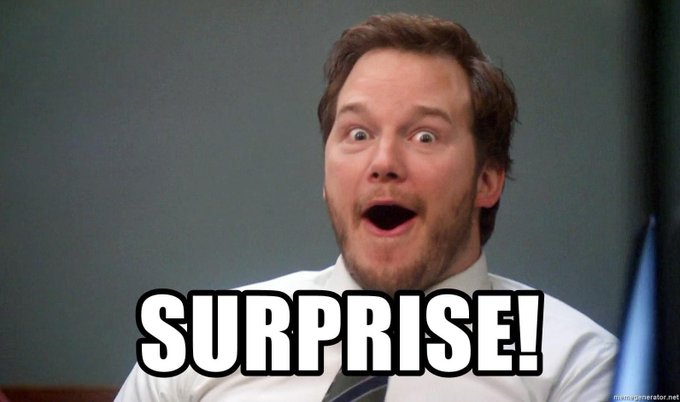

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [159]:
sample = pd.read_csv("data/sample_submission.csv")

In [160]:
sample.head()

laptop_ID  Price_in_euros
0        209          1949.1
1       1281           805.0
2       1168          1101.0
3       1231          1293.8
4       1020          1832.6

In [161]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [162]:
#¿Cómo creamos la submission?
submissionVprueba = pd.DataFrame({'laptop_ID': X_pred.index, 'Price_in_euros': predictions_submit})

In [167]:
submissionVprueba.head()

laptop_ID  Price_in_euros
0        209     1483.963379
1       1281      332.616394
2       1168      352.935333
3       1231     1058.401367
4       1020     1045.597290

In [164]:
submissionVprueba.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [165]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submissionVprueba.to_csv("submissionVprueba.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [166]:
chequeador(submissionVprueba)

You're ready to submit!


features num no escaladas

features cat get.dummies

Busqueda de best model entre RandomForest y Xgboost

mejor Xgboost 
busqueda de mejores paramestos con gridSearc

